In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

In [3]:
torch.manual_seed(42)

In [4]:
df = pd.read_csv('fmnist_small.csv')
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,125,72,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,3,0,2,0,0,210,228,228,233,0,0,0,0,0,0,0,0,0,31,81,133,184,201,190,117,0,0,2,1,0,7,0,50,205,196,213,165,0,0
1,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,0,43,117,34,15,24,33,117,80,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,51,144,152,...,157,158,161,148,159,58,0,6,0,0,0,0,0,0,0,0,0,4,0,60,143,143,148,146,152,152,148,148,147,145,142,142,142,21,0,3,0,0,0,0
3,8,0,0,0,0,0,0,0,0,0,0,0,0,2,0,33,114,37,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,11,17,13,13,11,10,7,5,5,5,7,0,0,0,1,0,0,41,69,88,86,94,106,114,118,47,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,8,0,0,0,0,0,0,0,0,0,0,2,0,58,145,114,10,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,...,165,153,155,134,143,172,215,62,0,0,0,0,0,0,0,0,10,190,178,194,209,211,209,205,211,215,213,217,225,228,213,203,174,151,188,10,0,0,0,0


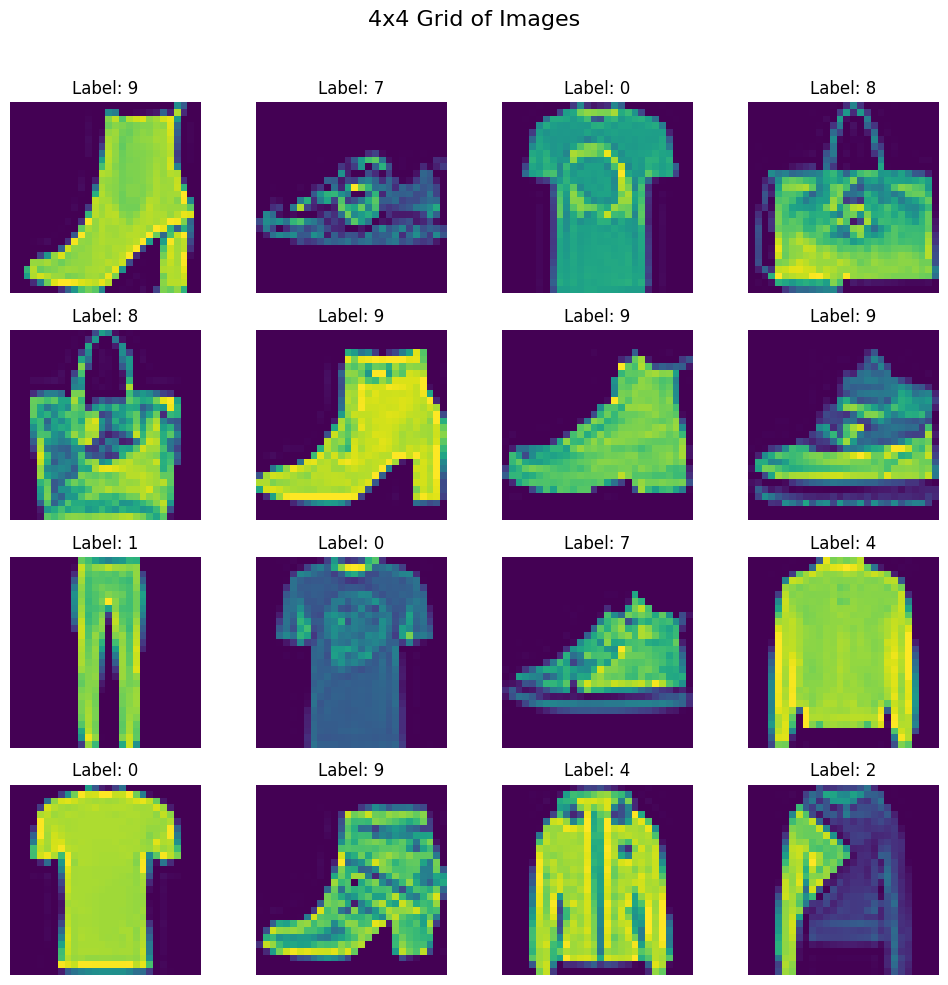

In [5]:
#Create a 4x4 grid of images
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
fig.suptitle('4x4 Grid of Images', fontsize=16)

#Plot the 1st 16 images from the dataset
for i, ax in enumerate(axes.flat):
    img = df.iloc[i, 1:].values.reshape(28,28)
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f"Label: {df.iloc[i,0]}")

plt.tight_layout(rect=[0,0,1,0.96])
plt.show()

In [6]:
# train test split
X = df.iloc[:,1:].values
y = df.iloc[:,0].values

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# scaling the features
X_train = X_train/255.0
X_test = X_test/255.0

In [9]:
X_train

array([[0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       ...,
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.0627451, 0.       ,
        0.       ]])

In [12]:
# create CustomDataset class

class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, index):
       return self.features[index], self.labels[index]

In [13]:
# Create train_dataset object
train_dataset = CustomDataset(X_train, y_train)

In [14]:
len(train_dataset)

4800

In [15]:
train_dataset[0]

(tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0

In [16]:
#create test_dataset object
test_dataset = CustomDataset(X_test, y_test)

In [17]:
# Create train and test loader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [21]:
# define NN class

class MyNN(nn.Module):

  def __init__(self,num_features):

    super().__init__()
    self.model = nn.Sequential(
        nn.Linear(num_features, 128),
        nn.ReLU(),
        nn.Linear(128,64),
        nn.ReLU(),
        nn.Linear(64,10)
    )

  def forward(self,x):
    return self.model(x)

In [22]:
# set learning rate and epochs
epochs= 100
learning_rate =0.1

In [23]:
# instantiate the model
model = MyNN(X_train.shape[1])

# loss function
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

In [25]:
# training loop

for epoch in range(epochs):

  total_epoch_loss = 0

  for batch_features, batch_labels in train_loader:

    # forward pass
    outputs = model(batch_features)

    # loss
    loss = criterion(outputs, batch_labels)

    # backward pass
    optimizer.zero_grad()
    loss.backward()

    #update params
    optimizer.step()

    total_epoch_loss = total_epoch_loss + loss.item()

  avg_loss = total_epoch_loss/len(train_loader)
  print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}')

Epoch 1/100, Loss: 1.3053
Epoch 2/100, Loss: 0.7725
Epoch 3/100, Loss: 0.6581
Epoch 4/100, Loss: 0.5727
Epoch 5/100, Loss: 0.5300
Epoch 6/100, Loss: 0.5010
Epoch 7/100, Loss: 0.4626
Epoch 8/100, Loss: 0.4479
Epoch 9/100, Loss: 0.4212
Epoch 10/100, Loss: 0.3990
Epoch 11/100, Loss: 0.3798
Epoch 12/100, Loss: 0.3575
Epoch 13/100, Loss: 0.3521
Epoch 14/100, Loss: 0.3423
Epoch 15/100, Loss: 0.3200
Epoch 16/100, Loss: 0.3200
Epoch 17/100, Loss: 0.3015
Epoch 18/100, Loss: 0.2842
Epoch 19/100, Loss: 0.2821
Epoch 20/100, Loss: 0.2676
Epoch 21/100, Loss: 0.2677
Epoch 22/100, Loss: 0.2470
Epoch 23/100, Loss: 0.2342
Epoch 24/100, Loss: 0.2312
Epoch 25/100, Loss: 0.2200
Epoch 26/100, Loss: 0.2136
Epoch 27/100, Loss: 0.2143
Epoch 28/100, Loss: 0.3188
Epoch 29/100, Loss: 0.2599
Epoch 30/100, Loss: 0.2163
Epoch 31/100, Loss: 0.1874
Epoch 32/100, Loss: 0.1843
Epoch 33/100, Loss: 0.1900
Epoch 34/100, Loss: 0.1777
Epoch 35/100, Loss: 0.1643
Epoch 36/100, Loss: 0.1667
Epoch 37/100, Loss: 0.1639
Epoch 38/1

In [26]:
# evaluation mode
model.eval()

MyNN(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [28]:
# evaluation code
total = 0
correct = 0

with torch.no_grad():

  for batch_features, batch_labels in test_loader:

    # forward pass
    outputs = model(batch_features)
    _, predicted = torch.max(outputs, 1)

    # update total and correct
    total += batch_labels.shape[0]
    correct += (predicted == batch_labels).sum().item()

  print(correct/total)

0.8316666666666667


In [27]:
len(test_loader)

38

#How to improve this accuracy in the subsequent modules ....???



*   By using the full dataset of 70,000 images and not just these 6000 images for training. But for that we need to learn how to train on the GPU using PyTorch in the next section!
*   By trying out various optimizers such as SGD, Adam, RMSProp, AdaGrad, etc.
*   By using hyperparameter tuning to change the model architecture by trying out various number of neurons in each hidden layer..
*   By trying to change the learning rate, number of epochs, activation functions, loss function, etc.
*   By tring out special image processing pieplines such as CNN, UNets, VGGNet, ResNet, MobileNet, etc. as the fashion mnist dataset primarity contains pixel values and hence other feature engineerings can't be performed.

